In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../../../')
import set_plot_sizes

sys.path.append('../../../../../cosmosis_wrappers/') # change to correct path
import ABC_saved_sims_multiparam

from tqdm import tqdm_notebook as tqdm

# change to the path where ABCPMC git clone is located
sys.path.insert(0,'../../../../../../abcpmc/')
import abcpmc # find citation at https://github.com/jakeret/abcpmc

sys.path.append('../../../../../latinhypercube/') # change to correct path
import generate_hypercube

import corner

In [2]:
print ("This is in the Omega_m and sigma8 plane")

This is in the Omega_m and sigma8 plane


In [3]:
data_dir = './hypercube/' #/to_keep_safe

In [29]:
!pwd 
# !ls

/net/reusel/data1/osinga/master_research_project/master_research_project/learning_purposes/v2_IMNN/weak_lensing_multibins/2param/sigma8


In [5]:
class holder(object):
    """Small class because plotting function requires it"""
    def __init__(self,saveversion,figuredir):
        self.modelversion = saveversion
        self.figuredir = figuredir
        

modelversion = 10
noiseless = False
holder1 = holder(saveversion=modelversion,figuredir='./hypercube/')
theta_fid = np.array([0.315,0.811]) # Omega_M, sigma8

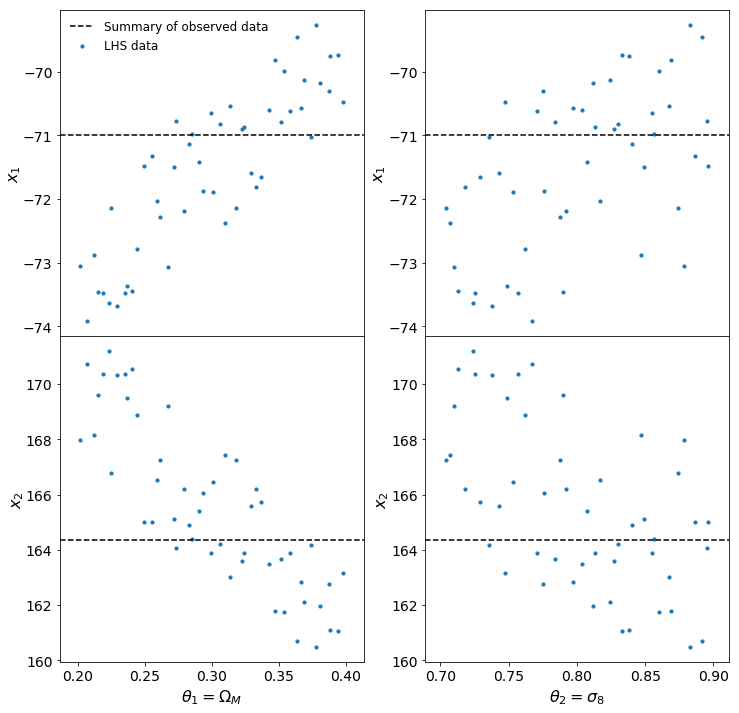

In [6]:
# I generated 50 samples, for 2 params
# with criterion = 'maximin'
# using uniform for Omega_m between 0.2 and 0.4
# and uniform for S8 between 0.7 and 0.9
# The parameters according to lhs
theta_lhd = np.load(f'{data_dir}theta_lhd_{modelversion}_{noiseless}.npy')
# The Cells
lhd_Cls = np.load(f'{data_dir}lhd_Cls_{modelversion}_{noiseless}.npy')

# The fisher info on the real data
fisher = np.load(f'{data_dir}realfisher_{modelversion}_{noiseless}.npy')

# The summaries
summaries = np.load(f'{data_dir}lhd_summaries_{modelversion}_{noiseless}.npy')
realsummary = np.load(f'{data_dir}realsummary_{modelversion}_{noiseless}.npy')
# Plot the summaries
generate_hypercube.plot_hypercube_summaries(theta_lhd, summaries
    , holder1, theta_fid, realsummary, oneD=True, hbins=20
    , xlabels = [r"$\theta_1 = \Omega_M$", r"$\theta_2 = \sigma_8$"]
    , show=True)

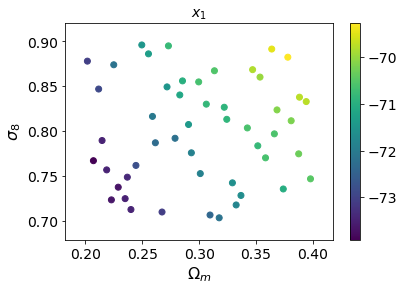

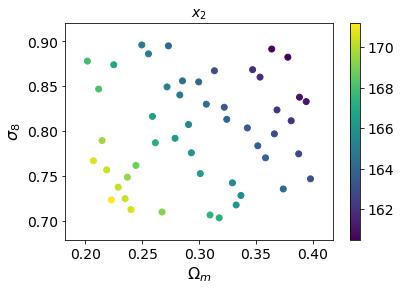

In [7]:
num = 50 # number of points to plot
plt.scatter(theta_lhd[:num,0],theta_lhd[:num,1]
            ,c=summaries[:num,0]);
plt.title("$x_1$")
plt.colorbar()
# plt.scatter(*theta_fid, c='k')
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.savefig(f'./hypercube/x1_{modelversion}.png',bbox_inches='tight')
plt.show()

num = 50 # number of points to plot
plt.scatter(theta_lhd[:num,0],theta_lhd[:num,1]
            ,c=summaries[:num,1]);
plt.title("$x_2$")
plt.colorbar()
# plt.scatter(*theta_fid, c='k')
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
# plt.legend(frameon=False);
plt.savefig(f'./hypercube/x2_{modelversion}.png',bbox_inches='tight')
plt.show()

Seems like it will be hard to fit x1 and x2 with a plane. X1 is OK, but x2 not very.

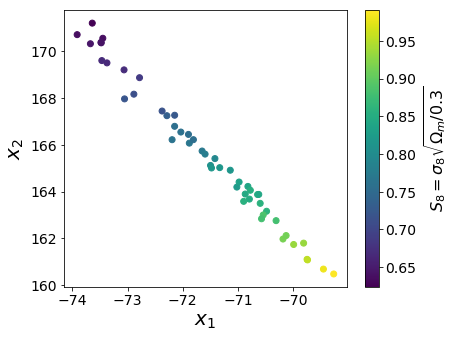

In [8]:
num = 50 # number of points to plot
fig, ax = plt.subplots(figsize=([6.4, 4.8]))
plt.scatter(summaries[:num,0],summaries[:num,1]
            ,c=theta_lhd[:num,1]*np.sqrt(theta_lhd[:num,0]/0.3));
plt.xlabel("$x_1$",fontsize=set_plot_sizes.BIGGER_SIZE)
plt.ylabel("$x_2$",fontsize=set_plot_sizes.BIGGER_SIZE)
cbar = plt.colorbar()
cbar.set_label('$S_8 = \sigma_8 \sqrt{\Omega_m/0.3}$');
# plt.legend(frameon=False);
plt.tight_layout()
plt.savefig(f'./hypercube/x1x2scatter_{modelversion}.png')
plt.show()

In [9]:
np.corrcoef(summaries,rowvar=False)

array([[ 1.       , -0.9928777],
       [-0.9928777,  1.       ]])

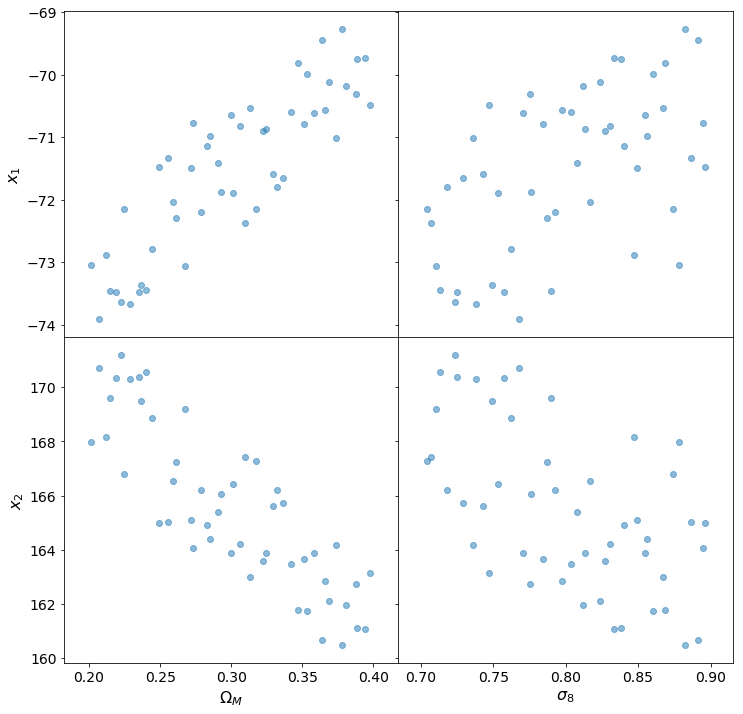

In [10]:
num = 50

fig, axes = plt.subplots(2,2,figsize=(12,12),sharex='col',
                        sharey='row')
plt.subplots_adjust(wspace=0,hspace=0)
ax = axes[0,0]
ax.scatter(theta_lhd[:num,0], summaries[:num,0],alpha=0.5)
# plt.xlabel('$\Omega_m$');
ax.set_ylabel('$x_1$')

ax = axes[1,0]
ax.scatter(theta_lhd[:num,0], summaries[:num,1],alpha=0.5)
ax.set_xlabel('$\Omega_M$');
ax.set_ylabel('$x_2$')

ax = axes[0,1]
ax.scatter(theta_lhd[:num,1], summaries[:num,0],alpha=0.5)
# plt.xlabel('$\Omega_m$');
# ax.set_ylabel('$x_1$')

ax = axes[1,1]
ax.scatter(theta_lhd[:num,1], summaries[:num,1],alpha=0.5)
ax.set_xlabel('$\sigma_8$');
# ax.set_ylabel('$x_2$')
plt.show()


In [11]:
def linleastsquares(X, y):
    """
    Fit linear least squares, given a matrix X
    X = shape (observations,num_params) (1000,2)
    y = observed data values -- shape = (1000,)
    
    returns beta -- best fit parameters -- shape (2,)
    """
    beta = np.dot((np.dot( np.linalg.inv(np.dot(X.T,X)), X.T)),y)   
    return beta

In [12]:
def plot_fit_result(model,xindx):
    """
    Plot a few images to show how well the model fits the data
    
    model -- function: the best fit model, should take two parameters: Omega_m and sigma_8
    xindx -- integer:  1 for fitting x1. 2 for fitting x2
    
    """
    # Calculate values according to the model
    omega_m = np.linspace(0.28,0.34,30)
    sigma_8 = np.linspace(0.70,0.90,30)
    xv, yv = np.meshgrid(omega_m, sigma_8)
    model_sol = model(xv,yv)

    plt.contourf(omega_m,sigma_8, model_sol);
    plt.title(f"Fit to $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()

    # color boundaries hardcoded
    if xindx == 1:
        vmin = summaries[:,0].min()-3
        vmax = summaries[:,0].max()+3
    if xindx == 2:
        vmin = summaries[:,1].min()-3
        vmax = summaries[:,1].max()+3
    
    num = 1000
    model_sol_scatter = model(theta_lhd[:num,0],theta_lhd[:num,1])
    plt.scatter(theta_lhd[:num,0],theta_lhd[:num,1], c=model_sol_scatter
                ,vmin=vmin,vmax=vmax);
    plt.title(f"Fit to $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()

    plt.scatter(theta_lhd[:num,0],theta_lhd[:num,1],c=summaries[:num,xindx-1]
                ,vmin=vmin,vmax=vmax);
    plt.title(f"Actual $x_{xindx}$")
    plt.colorbar()
    plt.xlabel('$\Omega_m$');
    plt.ylabel('$\sigma_8$')
    # plt.legend(frameon=False);
    plt.show()
    
def plot_fit_result1D(model,xindx):
    """
    Plot a few images in 1D to show how well the model fits the data
    
    model -- function: the best fit model, should take two parameters: Omega_m and sigma_8
    xindx -- integer:  1 for fitting x1. 2 for fitting x2
    
    """
    num = 50
    model_sol_scatter = model(theta_lhd[:num,0],theta_lhd[:num,1])
    plt.title(f"{num} points")
    plt.scatter(theta_lhd[:num,0], model_sol_scatter,alpha=0.5)
    plt.xlabel('$\Omega_m$');
    plt.ylabel(f'$x_{xindx}$')
    plt.show()

    plt.title(f"{num} points")
    plt.scatter(theta_lhd[:num,1], model_sol_scatter,alpha=0.5)
    plt.xlabel('$\sigma_8$');
    plt.ylabel(f'$x_{xindx}$')
    plt.show()

In [13]:
# Fit to the 50 points
num = 50
# Fit x1 = a\Omega_m + b\sigma_8 + c
X = np.array([theta_lhd[:num,0], theta_lhd[:num,1], np.ones(num)]).T # (1000,3)
y = summaries[:num,0] # x1

ahat, bhat, chat = linleastsquares(X,y)
print ("My lstsq prediction:")
print (ahat,bhat, chat)


# Scipy values
# Residual function:
def resid(x, t, y):
    """
    x is in this case [a, b, c], the fitted model params
    t is in this case [Omega_m, sigma8, ones] (X array, 1000,3)
    y is in this case the real values, y (1000,)
    """
    predict = x[0]*t[:,0]+x[1]*t[:,1]+x[2]
    actual = y
    return predict - actual

from scipy.optimize import least_squares
x0 = np.ones(3) # initial estimate for ahat, bhat, chat
reslsq = least_squares(resid, x0, args=(X,y))
print ("Scipy lstsq:")
print (reslsq.x)
print ("We see that this is equivalent to linear least squares")
print ("That we have implemented")

My lstsq prediction:
18.207998913921188 10.701338380040141 -85.57176563997452
Scipy lstsq:
[ 18.2079989   10.70133841 -85.57176566]
We see that this is equivalent to linear least squares
That we have implemented


In [14]:
# Now do better, with a more robust loss function
# f_scale is now of crucial importance. It defines the soft margin
# between inlier and outlier residuals. 
# e.g., f_scale=1 means that outlier residuals are < 0.1.

# Don't know what value we should set for f_scale though
# so should probably experiment

f_scales = [0.1, 1, 10]

for f_scale in f_scales:

    resrobust = least_squares(resid, x0, loss='cauchy', f_scale=f_scale
                              ,args=(X,y))
    ahatsp, bhatsp, chatsp = resrobust.x
    print ("Scipy with cauchy loss:")
    print (ahatsp, bhatsp, chatsp)


    resrobust = least_squares(resid, x0, loss='soft_l1', f_scale=f_scale
                              ,args=(X,y))
    ahatsp, bhatsp, chatsp = resrobust.x
    print ("Scipy with soft_l1 loss:")
    print (ahatsp, bhatsp, chatsp)

Scipy with cauchy loss:
17.135694854648257 10.750236457043332 -85.26164441135353
Scipy with soft_l1 loss:
17.655717320461424 10.710449587516605 -85.39902276701292
Scipy with cauchy loss:
18.11509003749721 10.742958092008722 -85.57460441994603
Scipy with soft_l1 loss:
18.161765899106445 10.722482761086038 -85.57353711039403
Scipy with cauchy loss:
18.206944412450284 10.701859772289952 -85.5718373326595
Scipy with soft_l1 loss:
18.20747181888624 10.701599035456029 -85.57180150375837


Parameters are not very different now. We will use f_scale = 1 and L1 loss to fit it.

In [15]:
model = lambda x, y: ahat*x + bhat*y + chat

# lets use soft l1
resrobust = least_squares(resid, x0, loss='soft_l1', f_scale=1
                          ,args=(X,y))
ahatsp, bhatsp, chatsp = resrobust.x
print ("Scipy with soft_l1 loss:")
print (ahatsp, bhatsp, chatsp)

model_sp = lambda x, y: ahatsp*x + bhatsp*y + chatsp

Scipy with soft_l1 loss:
18.161765899106445 10.722482761086038 -85.57353711039403


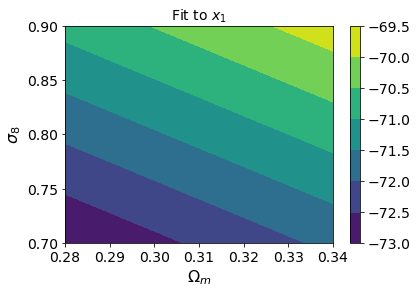

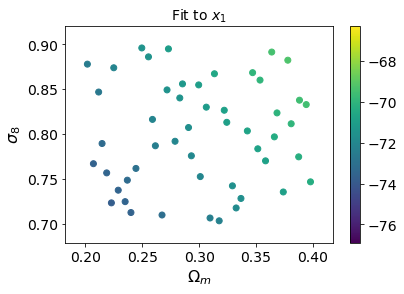

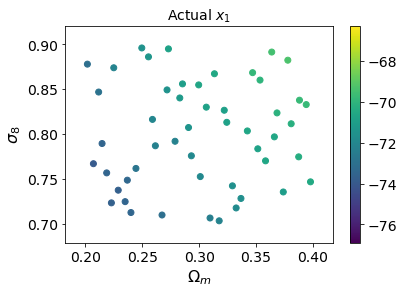

Scipy values


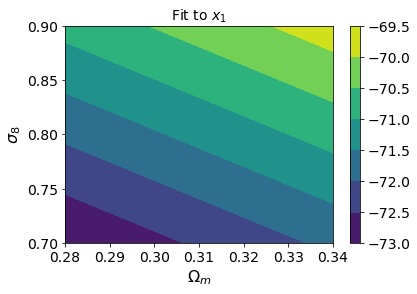

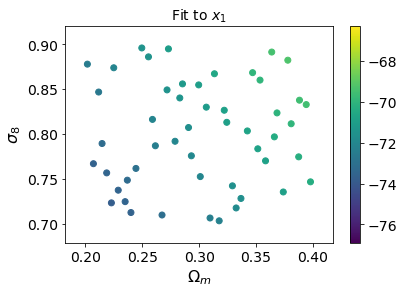

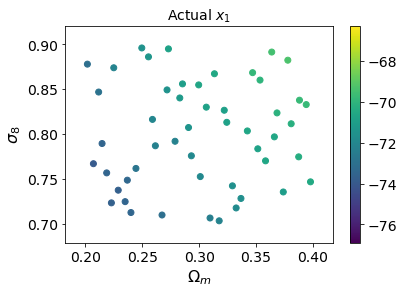

In [16]:
plot_fit_result(model,xindx=1)
print ("Scipy values")
plot_fit_result(model_sp,xindx=1)

#### I think the fit looks very good

In [17]:
# Fit to x2, same procedure
num = 50
# Fit x1 = a\Omega_m + b\sigma_8 + c
X = np.array([theta_lhd[:num,0], theta_lhd[:num,1], np.ones(num)]).T # (1000,3)
y2 = summaries[:num,1] # x2

ahat2, bhat2, chat2 = linleastsquares(X,y2)
print (ahat2,bhat2, chat2)

-41.91445186841298 -26.59211639131985 199.36863384785966


In [18]:
# Now do better, with a more robust loss function
# f_scale is now of crucial importance. It defines the soft margin
# between inlier and outlier residuals. 
# e.g., f_scale=1 means that outlier residuals are < 0.1.

# Don't know what value we should set for f_scale though
# so should probably experiment

f_scales = [0.1, 1, 10]
# f_scales = [1]

for f_scale in f_scales:

    resrobust = least_squares(resid, x0, loss='cauchy', f_scale=f_scale
                              ,args=(X,y2))
    ahat2sp, bhat2sp, chat2sp = resrobust.x
    print ("Scipy with cauchy loss:")
    print (ahat2sp, bhat2sp, chat2sp)


    resrobust = least_squares(resid, x0, loss='soft_l1', f_scale=f_scale
                              ,args=(X,y2))
    ahat2sp, bhat2sp, chat2sp = resrobust.x
    print ("Scipy with soft_l1 loss:")
    print (ahat2sp, bhat2sp, chat2sp)

Scipy with cauchy loss:
-39.734225529462 -25.893155822183342 198.05588946197662
Scipy with soft_l1 loss:
-41.80129477917679 -26.595318779488597 199.31458477771483
Scipy with cauchy loss:
-41.903567753559315 -26.605243906574405 199.37259870430293
Scipy with soft_l1 loss:
-41.90912704400689 -26.598597860032402 199.3706250375526
Scipy with cauchy loss:
-41.914327537662224 -26.59226044086123 199.36867718665533
Scipy with soft_l1 loss:
-41.91439004038005 -26.59218877570206 199.36865592801


We see that the f scale does change the values significantly. We will use f scale = 1

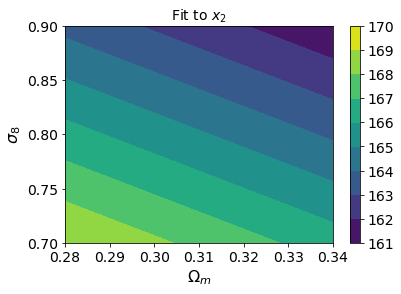

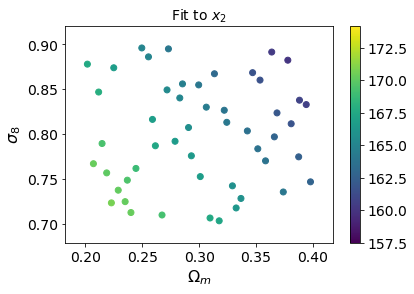

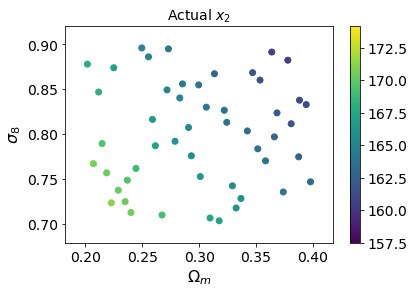

Scipy with soft_l1 loss:
-41.91439004038005 -26.59218877570206 199.36865592801
Scipy fit


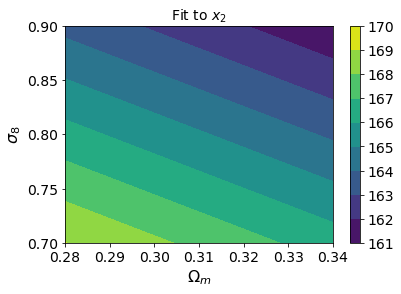

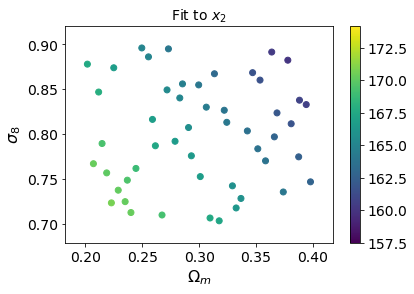

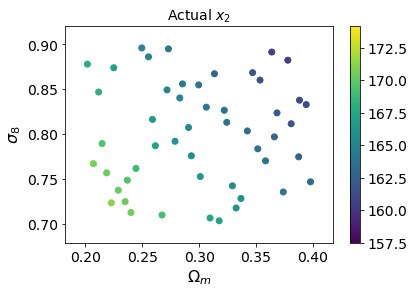

In [19]:
model2 = lambda x, y: ahat2*x + bhat2*y + chat2
plot_fit_result(model2,xindx=2)

resrobust = least_squares(resid, x0, loss='soft_l1', f_scale=f_scale
                          ,args=(X,y2))
ahat2sp, bhat2sp, chat2sp = resrobust.x
print ("Scipy with soft_l1 loss:")
print (ahat2sp, bhat2sp, chat2sp)
model2_sp = lambda x, y: ahat2sp*x + bhat2sp*y + chat2sp

print ("Scipy fit")
plot_fit_result(model2_sp,xindx=2)

#### We can also analytically solve the following eqs
\begin{equation}
\begin{split}
x^{\mathrm{fid}}_1 = a_1 \Omega_m + b_1 \sigma_8 + c_1 \\
x^{\mathrm{fid}}_2 = a_2 \Omega_m + b_2 \sigma_8 + c_2\\
\end{split}
\end{equation}
#### to find $\Omega_m$ and $\sigma_8$ given some fid params. (This is actually what the MLE does but worse).

In [52]:
print (realsummary)
print (ahatsp, bhatsp)
print (ahat2sp, bhat2sp)

[[-70.98828 164.3552 ]]
18.161765899106445 10.722482761086038
-41.91439004038005 -26.59218877570206


In [62]:
def solve_sigma8(a1, b1, c1, a2, b2, c2, realsummary):
    """
    Given the fitted function, we can solve analytically for
    Omega_m and sigma8, here we solve for sigma8 first
    """
    x1 = realsummary[0,0]
    x2 = realsummary[0,1]
    
    sigma8 = -(x1-c1)*a2/a1 -c2 + x2
    sigma8 /= b2 - a2*b1/a1
    
    return sigma8


def solve_omega_m(a1, b1, c1, realsummary, sigma8):
    """
    After we have sigma8, we only need the first equation to
    solve for omega_m
    """
    x1 = realsummary[0,0]
    
    omega_m = x1-b1*sigma8-c1
    omega_m /= a1
    return omega_m

In [74]:
sigma8 = solve_sigma8(ahatsp, bhatsp, chatsp
                    , ahat2sp, bhat2sp, chat2sp, realsummary)
omega_m = solve_omega_m(ahatsp, bhatsp, chatsp, realsummary, sigma8)

print ("Inferred best parameters from the fit")
print (f"Omega_m, sigma8 = {omega_m, sigma8}")
print ("\n")
print ("Output summary on real data")
print (realsummary[0])

print ("Output summary with inferred params from fit")
print (ahatsp*omega_m + bhatsp*sigma8 + chatsp)
print (ahat2sp*omega_m + bhat2sp*sigma8 + chat2sp)

print ("Using fid params with the fit formula:")
print (ahatsp*0.315 + bhatsp*0.811 + chatsp)
print (ahat2sp*0.315 + bhat2sp*0.811 + chat2sp)

Inferred best parameters from the fit
Omega_m, sigma8 = (0.37044033862482495, 0.73279718193815)


Output summary on real data
[-70.98828 164.3552 ]
Output summary with inferred params from fit
-70.98828125
164.35519409179688
Using fid params with the fit formula:
-71.15664733293472
164.59935796819593


#### Now using just the least square fit:

In [75]:
sigma8 = solve_sigma8(ahat, bhat, chat
                    , ahat2, bhat2, chat2, realsummary)
omega_m = solve_omega_m(ahat, bhat, chat, realsummary, sigma8)

print ("Inferred best parameters from the fit")
print (f"Omega_m, sigma8 = {omega_m, sigma8}")
print ("\n")

print ("Output summary on real data")
print (realsummary[0])

print ("Output summary with inferred params from fit")
print (ahat*omega_m + bhat*sigma8 + chat)
print (ahat2*omega_m + bhat2*sigma8 + chat2)

print ("Using fid params with the fit formula:")
print (ahat*0.315 + bhat*0.811 + chat)
print (ahat2*0.315 + bhat2*0.811 + chat2)

Inferred best parameters from the fit
Omega_m, sigma8 = (0.367899065861725, 0.7368030351267175)


Output summary on real data
[-70.98828 164.3552 ]
Output summary with inferred params from fit
-70.98828125
164.35519409179688
Using fid params with the fit formula:
-71.15746055587678
164.59937511594916


#### Both are very biased towards the high $\Omega_m$ and low $\sigma_8$.

#### Now perform ABC with the function that generates x1 and x2, no cosmosis needed.

In [20]:
import tensorflow as tf
# change to the path where the IMNN git clone is located
# new version of IMNN by Tom
sys.path.insert(-1,'../../../../../../IMNNv2/IMNN/')
import IMNN.ABC.priors as priors

In [21]:
def output_summaries(theta,model1,model2):
    """
    Return x1,x2 for a given theta = list of [Omega_m, sigma_8]'s' 
    given the two fitted models to x1 x2
    """
    theta = np.array(theta)
    Omega_m = theta[:,0]
    sigma_8 = theta[:,1]
    x1 = model1(Omega_m,sigma_8)
    x2 = model2(Omega_m,sigma_8)
    
    return np.array([x1,x2]).T # return as array of shape (len(theta),2)

In [22]:
def ABC_with_model(draws, real_summary, prior, model1, model2, fisher):

    Gaussprior = priors.TruncatedGaussian(prior["mean"],prior["variance"],prior["lower"]
                                    ,prior["upper"])
    # Draw params from Gaussian prior
    theta = Gaussprior.draw(draws)
    # Calculate summaries with models
    summaries = output_summaries(theta, model1,model2)
    # Calculate distance
    differences = summaries - real_summary
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    ABC_dict = dict()
    ABC_dict["summary"] = real_summary
    ABC_dict["fisher"] = fisher
    ABC_dict["parameters"] = theta
    ABC_dict["summaries"] = summaries
    ABC_dict["differences"] = differences
    ABC_dict["distances"] = distances
    
    return ABC_dict
    

In [45]:
# Variables for ABC
draws = int(1e5) # amount of draws
# A Truncated gaussian prior

# Basically a uniform prior
prior = {'mean': np.array([0.30,0.805]),
         'variance': np.array([[10,0],[0,10]]), # cov matrix
         #'variance': np.array([[0.01,0],[0,0.01]]), # cov matrix
         'lower': np.array([0.2,0.7]),
         'upper': np.array([0.4,0.9]) 
         }

In [46]:
abc_model = ABC_with_model(draws, realsummary, prior, model, model2, fisher)

# Also do scipy values
abc_modelsp = ABC_with_model(draws, realsummary, prior, model_sp, model2_sp, fisher)

### How do I know I am not just sampling the prior?

#### It does seem pretty dependent on the prior...

Epsilon is chosen to be 100.00
Number of accepted samples =  783


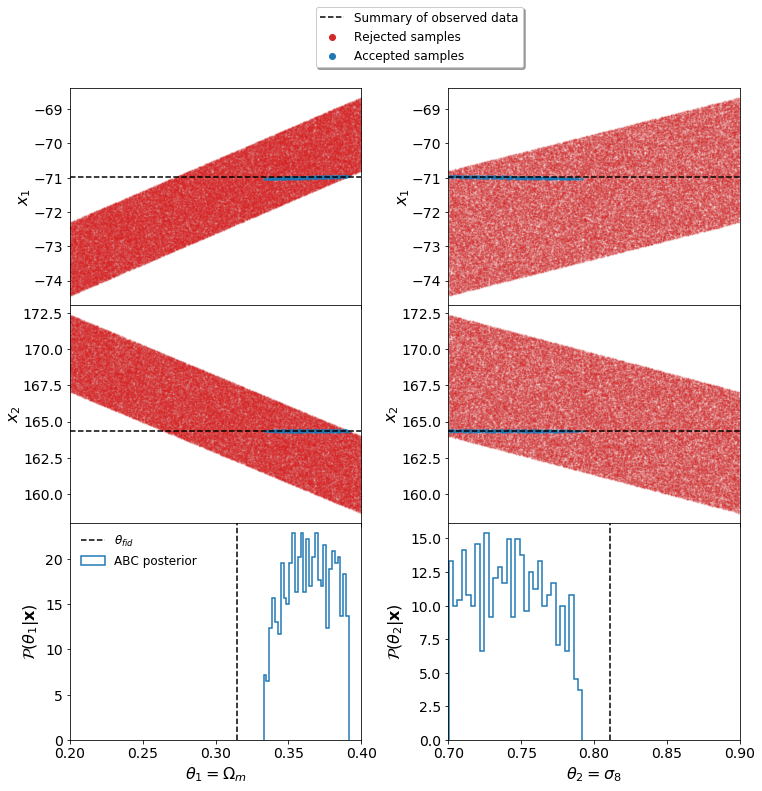

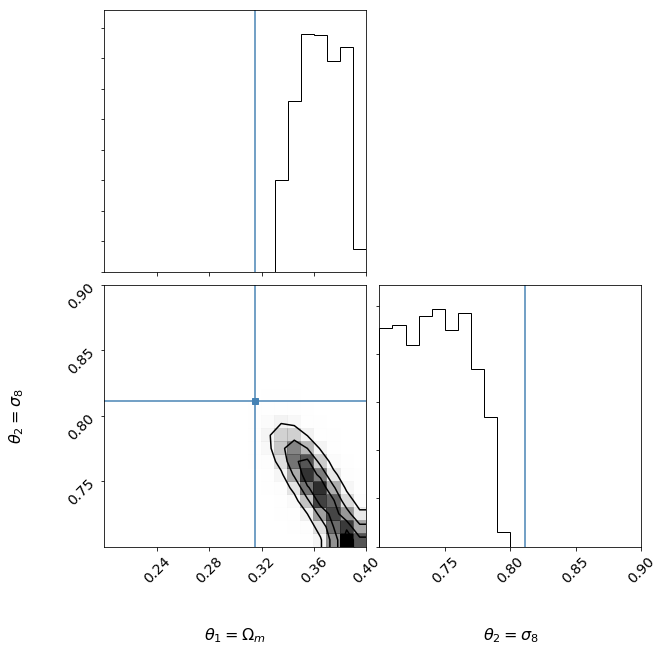

In [49]:
class holder(object):
    """Small class because plotting function requires it"""
    def __init__(self,saveversion,figuredir):
        self.modelversion = saveversion
        self.figuredir = figuredir
        

holder1 = holder(saveversion=modelversion,figuredir='./hypercube/')
theta_fid = np.array([0.315, 0.811])
# plotting function requires this too, does not depend on model 
# fitting though, so steal from earlier abc
abc_model["MLE"] = np.nan
ABC_saved_sims_multiparam.plot_ABC_2params(abc_model, holder1
                            , theta_fid, prior, oneD='both'
                            , hbins=30, epsilon=100,show=True)

Epsilon is chosen to be 100.00
Number of accepted samples =  786


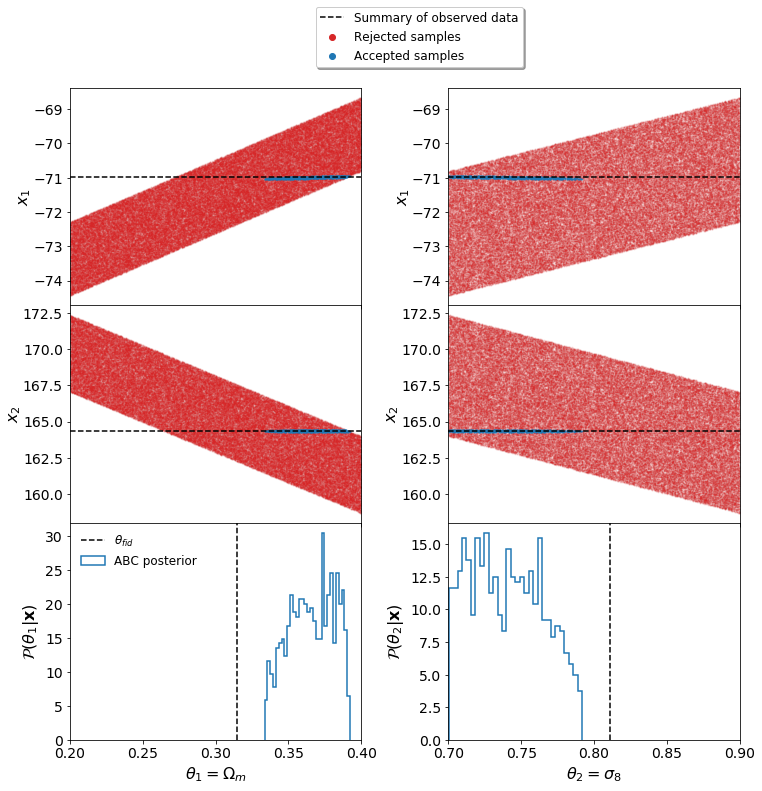

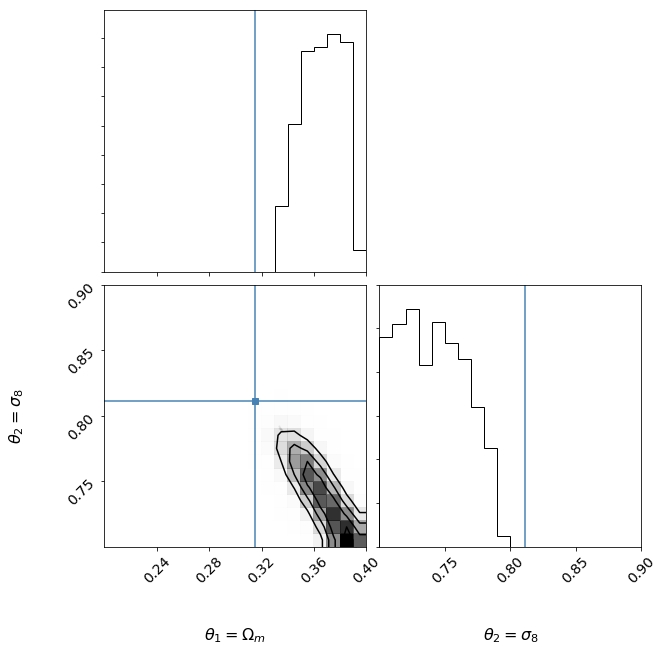

In [50]:
# Also for the scipy model, # make sure to put sp_ in front.
holder1 = holder(saveversion=modelversion,figuredir='./hypercube/sp_')
theta_fid = np.array([0.315, 0.811])
# plotting function requires this too, does not depend on model fitting though, so steal from earlier abc
abc_modelsp["MLE"] = np.nan

# prior = {'mean': np.array([0.30,0.805]),
#          'variance': np.array([[0.01,0],[0,0.01]]), # cov matrix
#          'lower': np.array([0.0,0.4]),
#          'upper': np.array([1.0,1.2]) 
#          }

# epsilon = 80
ABC_saved_sims_multiparam.plot_ABC_2params(abc_modelsp, holder1
    , theta_fid, prior, oneD='both', hbins=30
    , epsilon=100,show=True)


In [41]:
from importlib import reload

In [28]:
reload(ABC_saved_sims_multiparam)

<module 'ABC_saved_sims_multiparam' from '../../../../../cosmosis_wrappers/ABC_saved_sims_multiparam.py'>